In [9]:
# --- CELL 1: SETUP & LOAD DATA ---
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# Konfigurasi Style Plot agar terlihat profesional
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.dpi': 120})

# Load Data Metrics
METRICS_PATH = "app/ml/model_metrics.json"

try:
    with open(METRICS_PATH, "r") as f:
        metrics = json.load(f)
    print("✅ Berhasil memuat model_metrics.json")
    print(f"🔹 Silhouette Score: {metrics['silhouette_score']}")
    print(f"🔹 Inertia: {metrics['inertia']}")
except FileNotFoundError:
    print("❌ File tidak ditemukan. Pastikan Anda sudah menjalankan training model.")

✅ Berhasil memuat model_metrics.json
🔹 Silhouette Score: 0.2951
🔹 Inertia: 3105.85


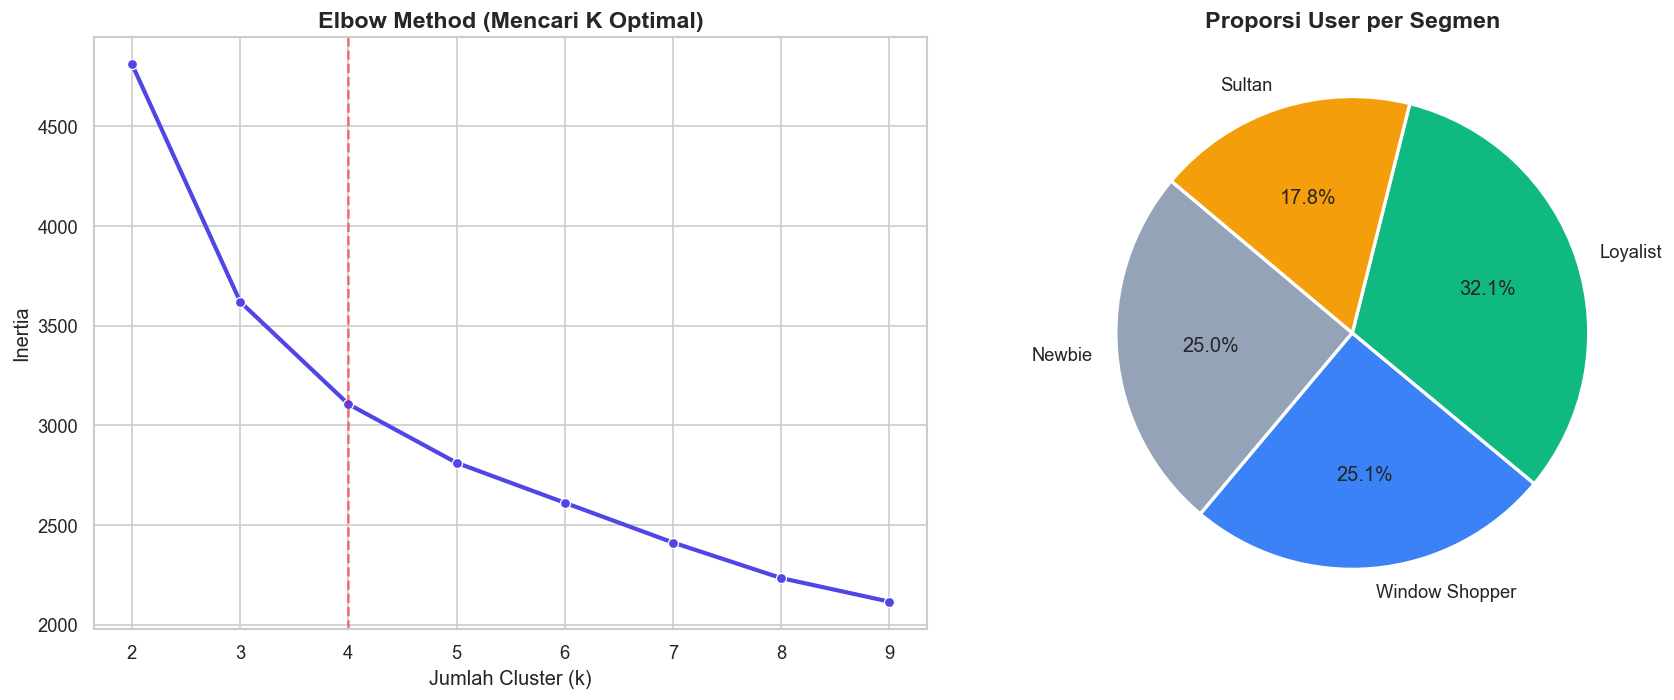

In [10]:
# --- CELL 2: ELBOW & POPULATION ---

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Elbow Curve (Kiri)
elbow_data = metrics['elbow_curve']
ks = list(elbow_data.keys())
inertias = list(elbow_data.values())

sns.lineplot(x=ks, y=inertias, marker='o', ax=axes[0], color='#4f46e5', linewidth=2.5)
axes[0].set_title('Elbow Method (Mencari K Optimal)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Jumlah Cluster (k)')
axes[0].set_ylabel('Inertia')
axes[0].axvline(x=2, color='red', linestyle='--', alpha=0.5) # Menandai K=4 (sesuaikan indeks list jika perlu)

# 2. Pie Chart User Distribution (Kanan)
cluster_counts = metrics['cluster_counts']
labels = metrics['cluster_names']
sizes = list(cluster_counts.values())
colors = ['#94a3b8', '#3b82f6', '#10b981', '#f59e0b'] # Warna tema dashboard

axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, 
            wedgeprops={'edgecolor': 'white', 'linewidth': 2})
axes[1].set_title('Proporsi User per Segmen', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

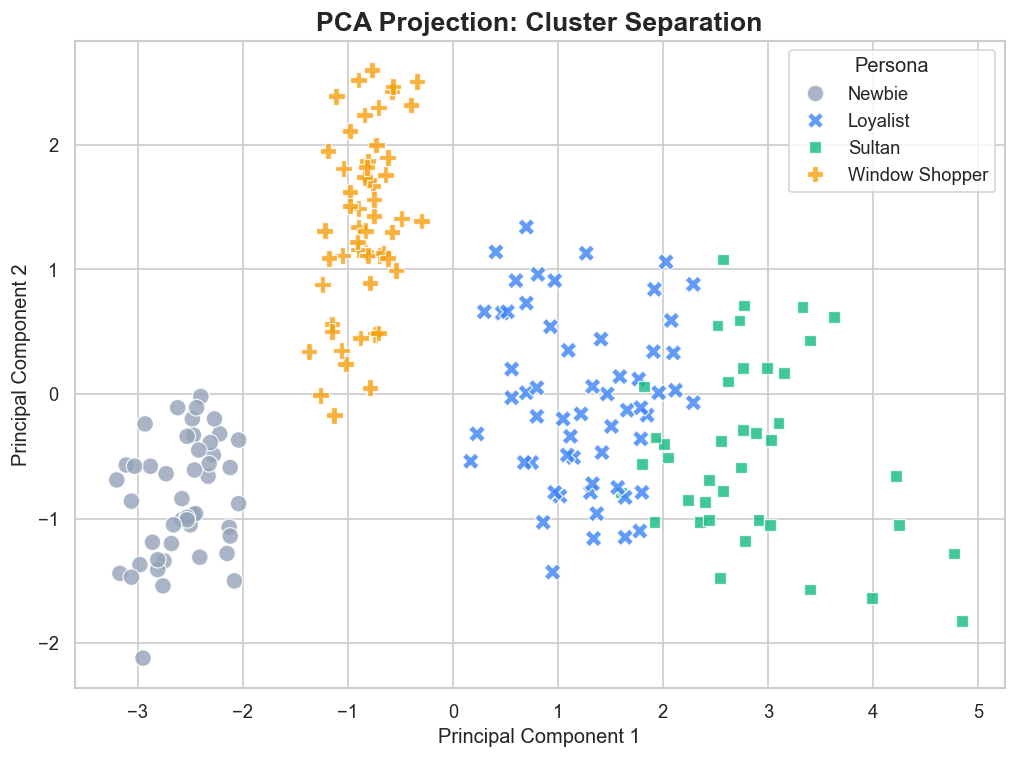

In [11]:
# --- CELL 3: PCA CLUSTER VISUALIZATION ---

if 'advanced_viz' in metrics and 'pca_scatter' in metrics['advanced_viz']:
    pca_data = metrics['advanced_viz']['pca_scatter']
    df_pca = pd.DataFrame(pca_data)
    
    # Mapping angka cluster ke nama (0 -> Newbie, dst)
    cluster_map = {i: name for i, name in enumerate(metrics['cluster_names'])}
    df_pca['Label'] = df_pca['cluster'].map(cluster_map)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=df_pca, x='x', y='y', hue='Label', style='Label',
        palette=['#94a3b8', '#3b82f6', '#10b981', '#f59e0b'], 
        s=100, alpha=0.8
    )
    
    plt.title('PCA Projection: Cluster Separation', fontsize=16, fontweight='bold')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Persona')
    plt.show()
else:
    print("⚠️ Data PCA tidak ditemukan di JSON.")

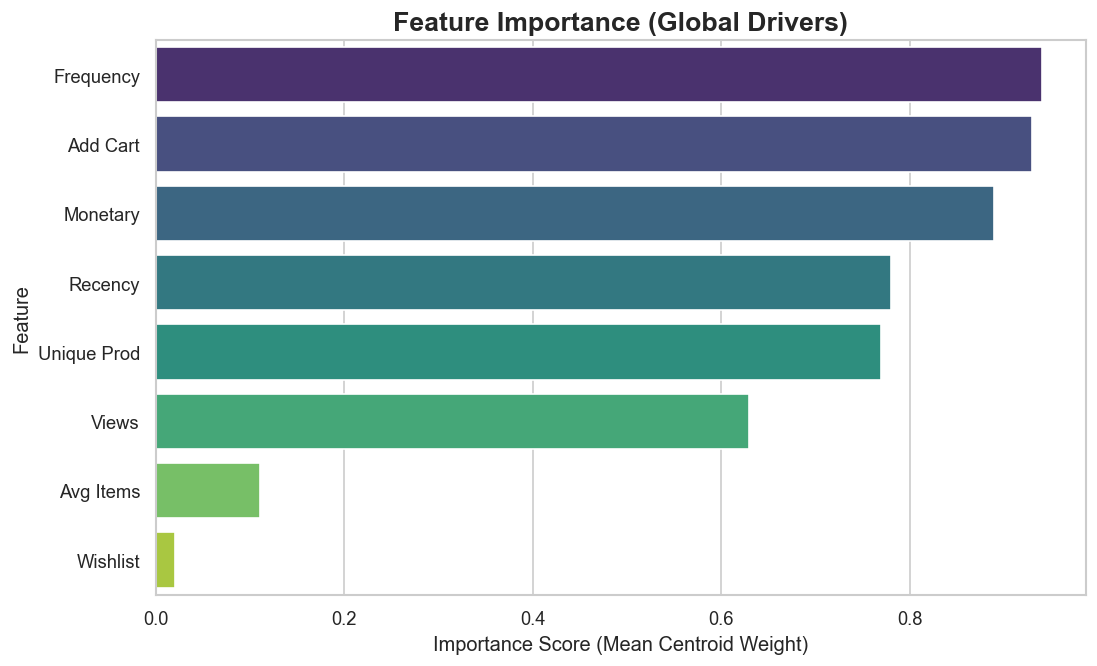

In [16]:
# --- CELL 4: FEATURE IMPORTANCE ---

if 'advanced_viz' in metrics and 'feature_importance' in metrics['advanced_viz']:
    fi_data = metrics['advanced_viz']['feature_importance']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
    x=fi_data['data'], 
    y=fi_data['labels'], 
    hue=fi_data['labels'], 
    palette="viridis", 
    legend=False         
)
    
    plt.title('Feature Importance (Global Drivers)', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score (Mean Centroid Weight)')
    plt.ylabel('Feature')
    plt.show()
else:
    print("⚠️ Data Feature Importance tidak ditemukan.")

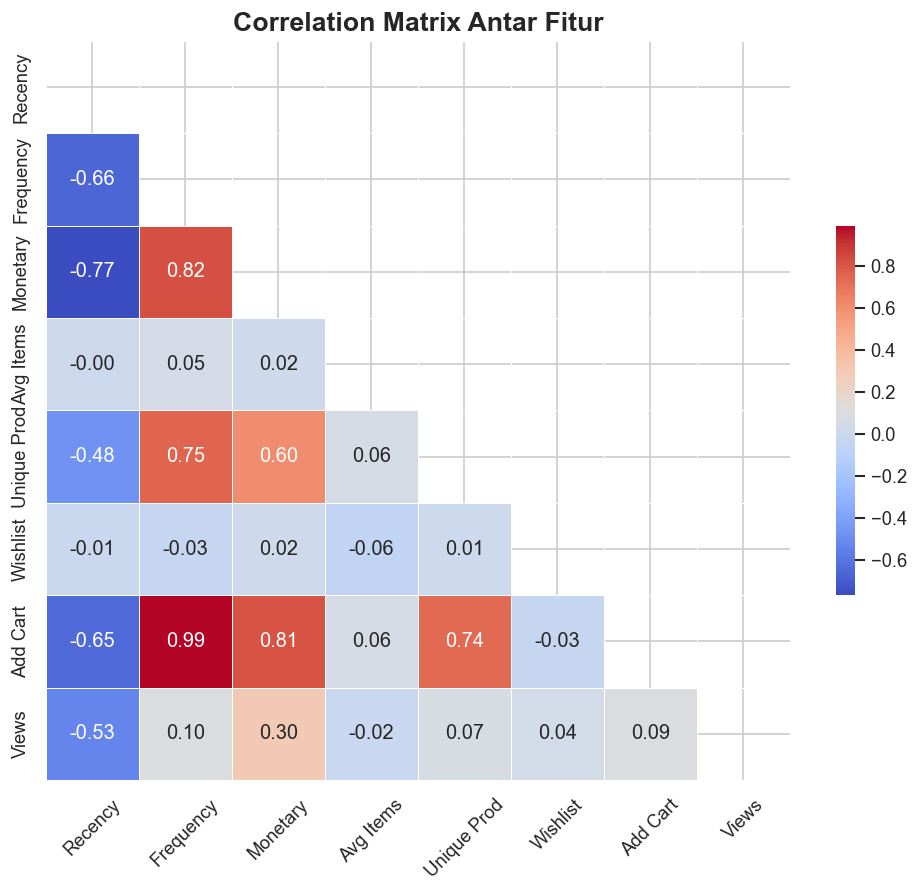

In [13]:
# --- CELL 5: CORRELATION HEATMAP ---

if 'advanced_viz' in metrics and 'correlation_matrix' in metrics['advanced_viz']:
    corr_data = np.array(metrics['advanced_viz']['correlation_matrix'])
    features = metrics['feature_readable']
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_data, dtype=bool)) # Masker segitiga atas
    
    sns.heatmap(
        corr_data, annot=True, fmt=".2f", cmap='coolwarm', 
        xticklabels=features, yticklabels=features,
        mask=mask, linewidths=.5, cbar_kws={"shrink": .5}
    )
    
    plt.title('Correlation Matrix Antar Fitur', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ Data Korelasi tidak ditemukan.")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

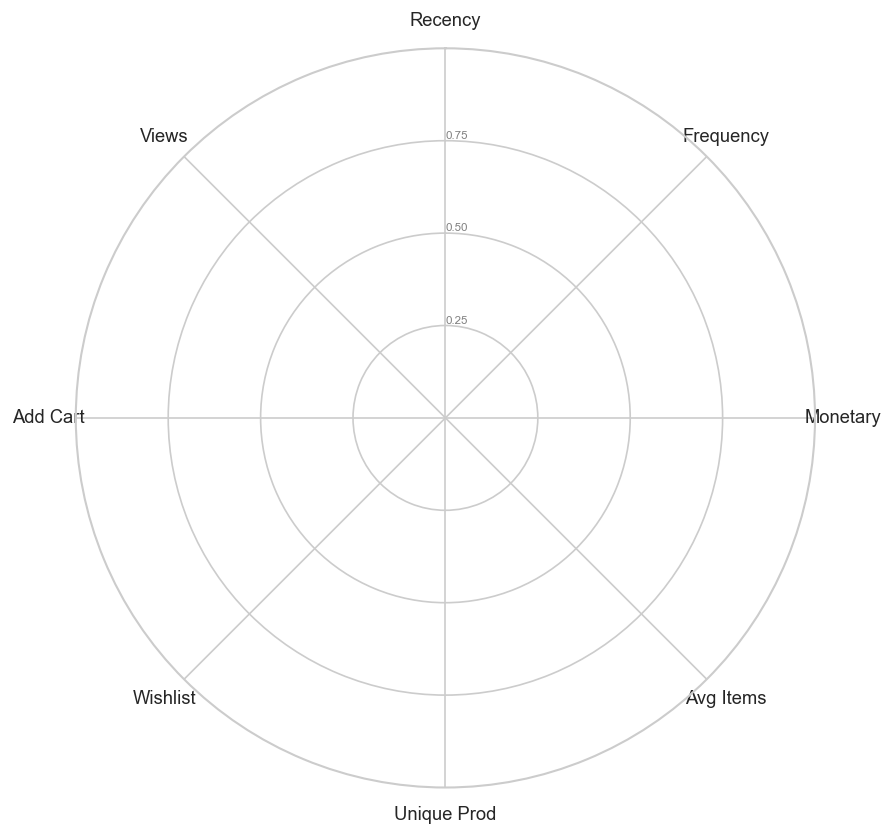

In [14]:
# --- CELL 6: RADAR CHART (CLUSTER DNA) ---

# Fungsi Helper untuk Radar Chart
def make_radar_chart(df, categories, title):
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Close the loop
    
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)
    plt.ylim(0, 1)
    
    colors = ['#94a3b8', '#3b82f6', '#10b981', '#f59e0b']
    
    for i, row in df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1] # Close the loop
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.index[i], color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)
    
    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Persiapkan Data
# Kita pakai Scaled Centroids agar grafiknya seimbang (0-1)
if 'centroids_scaled' in metrics:
    df_radar = pd.DataFrame(metrics['centroids_scaled'], columns=metrics['feature_readable'])
    df_radar.index = metrics['cluster_names']
    
    # Normalisasi MinMax manual agar chart terlihat penuh (opsional tapi bagus untuk visual)
    df_radar_norm = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())
    
    plt.figure(figsize=(8, 8))
    make_radar_chart(df_radar_norm, metrics['feature_readable'], "Cluster Persona DNA (Normalized)")
    plt.show()